In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime
import gmplot
import matplotlib.colors as cl
import geopandas as gpd
import time
from matplotlib import cm

from sklearn.neighbors import NearestNeighbors

### Functions

In [2]:
def distance(longitude1,latitude1,longitude2,latitude2):
    """
    Returns the distane between two latitude,longitude points using the Haversine metric (distance between two points on a great circle)
    Note: this is the same as the Haversine metric from sklearn which is output as A in nearest neighbor match below
    """
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    #haversine formula for a great circle distance
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082 #earth's radius in miles at London (0 elevation)
    
    return c*r

def get_file_contents(filename):
    """ 
    Given a filename, return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

def coord_retrieve(geometry):
    """
    For a GeoSeries (geopandas data format), retrieve all latitudes and longitudes and return them in a list
    Input must be in the format: GeoSeries.explode(index_parts=True)
    """
    
    length = len(geometry)
    
    lats = []
    longs = []
    
    for i in range(length):
        longs.append([coord[0] for coord in list(geometry[i].coords)])
        lats.append([coord[1] for coord in list(geometry[i].coords)])
        
    return lats,longs

def st2bool(x):
    """
    Converts TRUE/FALSE strings to boolean type
    """
    x[x=='TRUE'] = True
    x[x=='FALSE'] = False
    return x

## Loading and Cleaning

The following datasets are required for this notebook. **Due to their large size, these datasets are not stored in this repository**:
1. [cycling_safety_uk_gov.csv](https://zenodo.org/record/5603036#.Y49yTXbMJD9)<br/>
This dataset contains all accidents in the United Kingdom involving bikes from 2005-2018. This is a processed version of [Road Safety Data](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data) produced for the [CYCLANDS](https://www.nature.com/articles/s41597-022-01333-2) collection.

2. [dft_traffic_counts_aadf.csv](https://roadtraffic.dft.gov.uk/downloads)<br/>
This dataset contains the traffic annual average daily flows (aadf) for most roads in the United Kingdom from 2000-2021. More information on the dataset can be found [here](https://storage.googleapis.com/dft-statistics/road-traffic/all-traffic-data-metadata.pdf).

3. [cycle_lane_track.json](https://cycling.data.tfl.gov.uk/)
This dataset contains the location and classification of all bike lanes in Greater London. More information on the dataset can be found [here](https://cycling.data.tfl.gov.uk/CyclingInfrastructure/documentation/asset_information_guide.pdf).

### Loading

In [3]:
#Load in bike collisions for United Kingdom from 2005-2018
collisions = pd.read_csv('../../code-2022/Final Project/uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])

In [4]:
#Load in traffic flow data for United Kingdom from 2005-2018
aadf = pd.read_csv('../../code-2022/Final Project/uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [5]:
#Load in bike lanes for Greater London
cycle_lane_track = gpd.read_file('../Data/Dan_data/CyclingInfrastructure/Lines/cycle_lane_track.json')

### Cleaning

In [6]:
#road classes are encoded as integers in cycling_safety_uk_gov.csv (1st_Road_Class and 2nd_Road_Class variables)
#this array is for conversion from integer to string values
#note that 'na' corresponds to no 2nd road. 1st_Road_class does not have these values (-1)
#integers indexed at 0, hence black first value

road_classes = np.array(['','M','A(M)','A','B','C','U','na'])

In [7]:
#combine road_class and road_name variables to match single variable formatting of dft_traffic_counts_aadf.csv
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values
collisions['Road_name2'] = road_classes[collisions['2nd_Road_Class'].values].astype(object)+collisions['2nd_Road_Number'].apply(str).values

#remove 0 road number from U and C road classes to match dft_traffic_counts_aadf.csv (0 is just filler a road number and not a real number)
collisions.Road_name = collisions.Road_name.str.replace('U0','U')
collisions.Road_name = collisions.Road_name.str.replace('C0','C')
collisions.Road_name2 = collisions.Road_name2.str.replace('U0','U')
collisions.Road_name2 = collisions.Road_name2.str.replace('C0','C')

In [8]:
#Geographic corner values of London

##upper left, lower right corners of Greater London (lat,long)
corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

##upper left, lower right corners of Central London (lat,long)
# corners = [(51.543,-0.179),(51.475,0.023)]

In [9]:
#add boolean variable for in London
collisions['in_london']=[(collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()[0]

In [10]:
#add empty columns to traffic flow dataset for bike lane feature matching
aadf[cycle_lane_track.columns[:-3]] = np.nan

In [11]:
#add empty columns to collisions dataset for traffic flower counter matching
collisions['aadf_'+aadf.columns] = np.nan
collisions['distance_to_cp'] = np.nan
collisions['match'] = False

## Bike lane and traffic counter matching

### Extract data from cycle_lane_track.json

In [12]:
##This code black takes ~24 hours to run. It has already been run and output array saved. Skip to next code bloc,.

# Bike lane information is stored as GeoSeries for each safety feature. Each feature can be made up of multiple bike lanes. Need these converted to lists of latitudes and longitudes for each lane
# Below extracts longitudes/latitudes and stores them as numpy array of lists

# lats_coords = np.empty(len(cycle_lane_track),dtype=object)
# longs_coords = np.empty(len(cycle_lane_track),dtype=object)

# start = time.time()

# for i in range(len(cycle_lane_track)):
    
#     lats_coords[i],longs_coords[i] = coord_retrieve(cycle_lane_track.geometry.explode(index_parts=True)[i])
    
#     if i % 100 == 0:
#         print(i,time.time()-start)

# np.savez('longs_lats',longs=longs_coords,lats=lats_coords)

In [13]:
#Load in array from above code block
saved = np.load('longs_lats.npz',allow_pickle=True)

In [14]:
#calculate mean latitude and longitude of each safety feature
long_means = np.empty(len(saved['longs']))
lat_means = np.empty(len(saved['lats']))

for idx,i in enumerate(saved['longs']):
    long = np.array(i,dtype=object)
    long_means[idx] = np.mean(long).mean()
        
for idx,i in enumerate(saved['lats']):
    lat = np.array(i,dtype=object)
    lat_means[idx] = np.mean(lat).mean()
    
feature_means = pd.DataFrame({'Latitude':lat_means,'Longitude':long_means})

### Perform k-nearest neighbor matching of bike lanes and traffic counter points

In [15]:
# selection of k is based on analysis shown below
k_neighbor = 5000

#slice aadf counter point data within Greater London
aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

#find nearest 5000 safety features to each aadf counter point
#haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
#A is distance from safety feature to counter point
#B is aadf index of safety feature
#A and B are of size (len(feature_means),5000)
neigh = NearestNeighbors(n_neighbors=k_neighbor,metric='haversine')
neigh.fit(np.radians(feature_means[['Latitude','Longitude']]))
A,B = neigh.kneighbors(np.radians(aadf_year[['Latitude','Longitude']]))

In [16]:
# which safety feature classification from  cycle_lane_track to copy into aadf

features = ['CLT_CARR', 'CLT_SEGREG', 'CLT_STEPP',
       'CLT_PARSEG', 'CLT_SHARED', 'CLT_MANDAT', 'CLT_ADVIS', 'CLT_PRIORI',
       'CLT_CONTRA', 'CLT_BIDIRE', 'CLT_CBYPAS', 'CLT_BBYPAS', 'CLT_PARKR',
       'CLT_WATERR', 'CLT_PTIME']

In [17]:
#for each counter point, threshold on which features are within 0.1 miles
#For boolean safety feature classifications, apply OR logic across all bike lanes in safety feature to return single value for each classification
#For string safety feature classifications, create list of values for all bikes lanes in safety feature for each classification

#initialize lists for all string safety feature classifications
feature_id = np.empty(len(aadf),dtype=object)
svdate = np.empty(len(aadf),dtype=object)
clt_colour = np.empty(len(aadf),dtype=object)
borough = np.empty(len(aadf),dtype=object)

#Retrieve indices of sliced aadf data within Greater London to match to indices returned from NearestNeighbor
london_mask = np.argwhere(((aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])).values)

for idx in range(len(aadf_year)):
    
    london_idx = london_mask[idx][0]
    
    #check which features are within 0.1 miles
    mask = B[idx][A[idx]*3955.082 < 0.1]
    
    #apply OR filter
    values = cycle_lane_track.iloc[mask][features].apply(st2bool).any(axis=0).values
    
    #copy boolean safety feature classifications to aadf
    aadf.loc[aadf.index == london_idx,features] = values
    
    #create lists of string safety feature classifications
    feature_id[london_idx] = [cycle_lane_track.iloc[mask].FEATURE_ID.values.tolist()]
    svdate[london_idx] = [cycle_lane_track.iloc[mask].SVDATE.values.tolist()]
    clt_colour[london_idx] = [cycle_lane_track.iloc[mask].CLT_COLOUR.values.tolist()]
    borough[london_idx] = [cycle_lane_track.iloc[mask].BOROUGH.values.tolist()]

#copy string safety feature classifications to aadf
aadf['FEATURE_ID'] = feature_id
aadf['SVDATE'] = svdate
aadf['CLT_COLOUR'] = clt_colour
aadf['BOROUGH'] = borough

In [18]:
#slice aadf counter data for 2005-2018 (years we have collision data for)
aadf_london_col_years = aadf_year[pd.DataFrame(aadf_year.Year.dt.year.tolist(), index=aadf_year.index).isin(np.arange(2005,2019)).any(axis=1).values]

In [19]:
#save aadf dataframe with matched bike lane features

# aadf_london_col_years.to_csv('./aadf_features_london_colyears.csv',index=False)

### Check k value for above NearestNeighbor

In [20]:
# check if any aadf counter points had more than 5000 safety features within 0.1 miles

feature_lengths = np.zeros(len(A))

for idx,a in enumerate(A):
    link_length = aadf_year.iloc[idx].Link_length_miles
    if np.isnan(link_length):
        link_length = 0.1
    feature_lengths[idx] = np.count_nonzero(a*3955.082 < link_length)
    if feature_lengths[idx] == 5000:
        print(idx)

### Check statistics of matched safety features

In [21]:
#Check breakdown of counter points with and without bike lane features

aadf_london_col_years.CLT_CARR.value_counts()

Series([], Name: CLT_CARR, dtype: int64)

Text(0, 0.5, '# features')

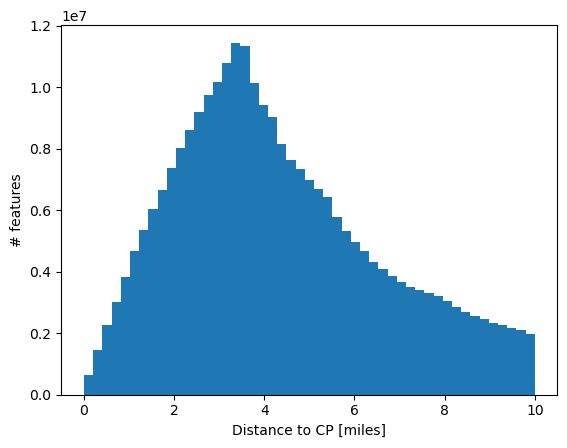

In [26]:
plt.hist(A.flatten()*3955.082,bins=np.linspace(0,10));
plt.xlabel('Distance to CP [miles]')
plt.ylabel('# features')

In [15]:
### Old versions of NearestNeighbor matching below

In [33]:
# feature_means = pd.DataFrame({'Latitude':lat_means,'Longitude':long_means})

# k_neighbor = 1

# #slice data within Greater London
# aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

# #find nearest k_neighbor aadf cp neighbors to collisions
# #haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
# #A is distance from collision to each neighbor
# #B is aadf index of neighbor
# #A and B are of size (len(collisions+year),k_neighbor)
# neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
# neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
# A,B = neigh.kneighbors(np.radians(feature_means[['Latitude','Longitude']]),k_neighbor)

# within = np.argwhere(A.flatten()*3955.082 < 0.1).flatten()

# print(aadf_year.iloc[B[within].flatten()].Year.value_counts())
# print()
# print(aadf_year.iloc[B[within].flatten()].Count_point_id.value_counts())
# print()
# print()

2018-01-01    1783
2000-01-01    1154
2019-01-01    1013
2021-01-01     673
2020-01-01     518
2008-01-01     510
2009-01-01     472
2001-01-01     323
2002-01-01     223
2007-01-01     221
2004-01-01     212
2003-01-01     209
2006-01-01     172
2010-01-01     162
2005-01-01     143
2017-01-01     133
2012-01-01     118
2016-01-01     100
2011-01-01      99
2014-01-01      92
2015-01-01      91
2013-01-01      56
Name: Year, dtype: int64

16188     38
16100     30
70193     27
47892     27
46201     26
          ..
942310     1
803377     1
16228      1
951701     1
810983     1
Name: Count_point_id, Length: 1925, dtype: int64




In [20]:
# feature_id = np.empty(len(aadf),dtype=object)
# # feature_id[:] = np.nan
# svdate = np.empty(len(aadf),dtype=object)
# # svdate[:] = np.nan
# clt_colour = np.empty(len(aadf),dtype=object)
# # clt_colour[:] = np.nan
# borough = np.empty(len(aadf),dtype=object)
# # borough[:] = np.nan

# indices = np.arange(0,len(aadf))

# for idx,count_id in enumerate(aadf_year.iloc[B[within].flatten()].Count_point_id.unique()):
    
#     mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id
#     values = cycle_lane_track.iloc[within].iloc[mask][features].apply(st2bool).any(axis=0).values
    
#     aadf.loc[aadf.Count_point_id == count_id,features] = values
    
#     mask_all = (aadf.Count_point_id == count_id).values
    
#     feature_id[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].FEATURE_ID.values.tolist()]
#     svdate[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].SVDATE.values.tolist()]
#     clt_colour[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].CLT_COLOUR.values.tolist()]
#     borough[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values.tolist()]
    
#     # aadf.loc[aadf.Count_point_id == count_id,'FEATURE_ID'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].FEATURE_ID.values])
#     # aadf.loc[aadf.Count_point_id == count_id,'SVDATE'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].SVDATE.values])
#     # aadf.loc[aadf.Count_point_id == count_id,'CLT_COLOUR'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].CLT_COLOUR.values])
#     # aadf.loc[aadf.Count_point_id == count_id,'BOROUGH'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values])

# aadf['FEATURE_ID'] = feature_id
# aadf['SVDATE'] = svdate
# aadf['CLT_COLOUR'] = clt_colour
# aadf['BOROUGH'] = borough

In [35]:
overlap_borough = []

for idx,count_id in enumerate(aadf_year.iloc[B[within].flatten()].Count_point_id.unique()):
    
    mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id
    boroughs = cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values
    
    if len(np.unique(boroughs[boroughs != np.array(None)])) > 1:
        # print(count_id)
        # print(cycle_lane_track.iloc[within].iloc[mask].BOROUGH)
        # print()
        overlap_borough.append(count_id)

## Accident and traffic counter matching

In [27]:
#create statistic counters
matches = 0
london_col = 0
london_col_nonan = 0
too_fars = 0

#how many aadf neighbors to compare each collision to. Typically each year has ~25 that have k>10.
k_neighbor = 50

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    aadf_mask = (aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])
    col_mask = (collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])
    
    #find nearest k_neighbor aadf cp neighbors to collisions
    #haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
    #A is distance from collision to each neighbor
    #B is aadf index of neighbor
    #A and B are of size (len(collisions+year),k_neighbor)
    neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
    neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
    A,B = neigh.kneighbors(np.radians(collisions_year[['Latitude','Longitude']]),k_neighbor)
    
    #find index of correct neighbor match
    match_idx = np.zeros((len(B),k_neighbor))
    
    #loop through k_neighbors and mark which ones have Road_name that matches 1st collision road name
    for i in range(k_neighbor):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
    
    #find closest neighbor with matching road names
    #need to set collisions with no match to -1 to not be confused with those where first neighbor (i.e. k=0) is match
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)    #this is 1d array of len(collisions_year) of which neighbor in B[i,:] is correct match (-1 is no match)
    
    #for collisions with no aadf match (i.e. check[i]=-1), look at 2nd labeled road in collision (Road_name2)
    for i in range(k_neighbor):
        match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
        match_idx[match2 & (check == -1),i] = 1
    
    #repeat this process now that 2nd road name matches have been filled in
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)
    
    #create boolean mask of matches
    match = np.where(check.astype(int) >= 0,True,False)
    
    #calculate distance from collision to match
    dist = A[np.arange(B.shape[0]),check]*3955.082
    
    #how many correct matches are within Link_length_miles
    too_far = (dist[match] <= aadf_year.iloc[B[np.arange(B.shape[0]),check][match]].Link_length_miles.values)
    
    #add correct aadf matches to collisions
    collisions.loc[np.where(col_mask)[0][match],'aadf_'+aadf.columns] = aadf.loc[aadf_mask].iloc[B[np.arange(B.shape[0]),check]][match].values
    #add correct matches to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'match'] = True
    #add distance_to_cp to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'distance_to_cp'] = A[np.arange(B.shape[0]),check][match][too_far]*3955.082
    
    ##calculate statistics
    
    B_match = B[np.arange(B.shape[0]),check][match]
    
    #count collisions in London
    london_col += len(collisions_year)
    london_col_nonan += len(collisions_year)
    
    #how many matches
    matches += match.sum()
    
    #of unmatched collisions, how many were U/C roads
    #try/except used as sometimes all U roads have matches
    try:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    except:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['C']].values.sum()/(check == -1).sum()

    #log how many total are outside boundary
    too_fars += too_far.sum()
    
    #which percent of collisions outside of Link_length_miles are due to nan Link_length_miles
    nan_outside = np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()/(np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()+(dist[match] > aadf_year.iloc[B_match].Link_length_miles.values).sum())
    
    #remove london collisions from count with nan Link_length_miles
    london_col_nonan -= np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()
    
    #how many collisions are within Link_length_miles
    #needed to cauclate large k's within boundaries
    too_far_all = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)
        
    
    print(year)
    print('mean distance to CP:',dist[match].mean())
    print('median distance to CP:',np.median(dist[match]))
    print('max distance to CP:',dist[match].max())
    print('min distance to CP:',dist[match].min())
    print()
    print('mean distance to CP within tracker boundary:',dist[match][too_far].mean())
    print('median distance to CP within tracker boundary:',np.median(dist[match][too_far]))
    print('max distance to CP within tracker boundary:',dist[match][too_far].max())
    print('min distance to CP within tracker boundary:',dist[match][too_far].min())
    print()
    print('Correct geo match:',match.sum())
    print('Correct geo match within tracker boundary:',too_far.sum())
    print('k>9 matches inside boundary',np.where((check > 9) & too_far_all,1,0).sum())
    print('largest k within boundary',np.max(check[too_far_all]))
    print('% outside boundary with nan value',nan_outside)
    print()
    print('Unlabeled unmatched collisions:',Unlabeled)
    print()
    print('Total London collisions:',len(collisions_year))
    print()
    print('% matched:',match.sum()/len(collisions_year))
    print('% matched in boundary:',too_far.sum()/len(collisions_year))
    print('% matched in boundary (not counting nan):',too_far.sum()/(len(collisions_year)-np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()))
    
    print()
    print()
    print()

print('total')
print('Correct geo match:',matches)
print('Correct geo match within tracker boundary:',too_fars)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)
print('% matched in boundary:',too_fars/london_col)
print('% matched in boundary (not counting nan):',too_fars/london_col_nonan)

C:\Users\tuthill.15\Anaconda3\envs\geo_env\Lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


2005
mean distance to CP: 0.4139035254218025
median distance to CP: 0.25003217948595274
max distance to CP: 5.358011966852259
min distance to CP: 0.0024900736781821777

mean distance to CP within tracker boundary: 0.2007601698757958
median distance to CP within tracker boundary: 0.1295936783983048
max distance to CP within tracker boundary: 2.612617688753044
min distance to CP within tracker boundary: 0.0024900736781821777

Correct geo match: 3073
Correct geo match within tracker boundary: 1803
k>9 matches inside boundary 23
largest k within boundary 46
% outside boundary with nan value 0.8913385826771654

Unlabeled unmatched collisions: 0.176

Total London collisions: 3323

% matched: 0.924766777008727
% matched in boundary: 0.5425820042130605
% matched in boundary (not counting nan): 0.8229119123687814



2006
mean distance to CP: 0.3971747976624115
median distance to CP: 0.2433006112990845
max distance to CP: 4.939897207887375
min distance to CP: 0.0025593925852251775

mean distance

In [43]:
# collisions.to_csv('./combined_collisions_v3.csv',index=False)

## Data Visualization

In [28]:
api_key = get_file_contents('../../code-2022/Final Project/Keys/google_maps.txt')

### Plot random collision from 2018 and all nearest aadf neighbors

Collision: 376
Neighbor index of match: 0
Found match: True
Match within boundary: False


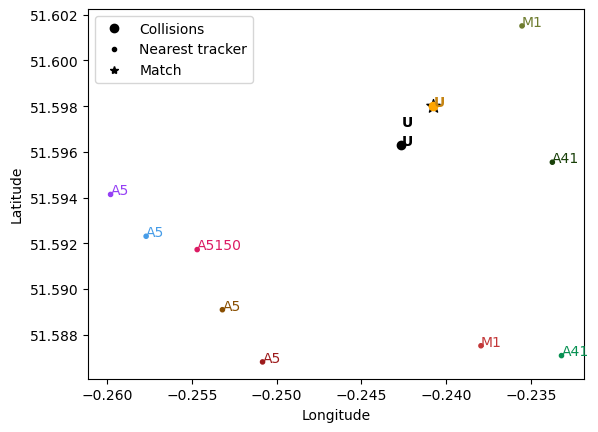

In [29]:
#index of collision to plot
plotN = np.random.randint(len(collisions_year))

#how many neighbors to plot
p_neighbor = 10

#if True will create .html with labeled map
gmp = True

print('Collision:',plotN)
print('Neighbor index of match:',check[plotN])
print('Found match:',match[plotN])
print('Match within boundary:',too_far_all[plotN])

#randomly create colors for neighbors
colors = np.random.rand(p_neighbor,3)

##plot collision
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#collision marker
ax.scatter(collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude,c='black')
#collision text Road_name
ax.annotate(collisions_year.iloc[plotN].Road_name, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude),color='black',weight='bold')

##plot neighbors
#neighbor markers
ax.scatter(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values,c=colors,marker='.')
#neibhor text Road_name
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values)):
    if i == check[plotN]:
        ax.annotate(txt, (long,lat),color=colors[i],weight='bold')
    else:
        ax.annotate(txt, (long,lat),color=colors[i])

#if match, plot start on matched neighbor
if check[plotN] != -1:
    ax.scatter(aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Latitude.values,c='black',marker='*',s=100)

#plot text of collision Road_name2
yspan = np.diff(ax.get_ylim())[0]   #calculates how far above first text to place second text
ax.annotate(collisions_year.iloc[plotN].Road_name2, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude+yspan/20),color='black',weight='bold')    

#collision marker
ax.scatter(collisions.loc[np.where(col_mask)[0][plotN]].aadf_Longitude,collisions.loc[np.where(col_mask)[0][plotN]].aadf_Latitude,c='orange')

##create legend
#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='.',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#plot legend
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

if gmp:
    gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,14,apikey=api_key)

    gmap1.marker(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, color='blue')
    road_name = collisions_year.iloc[plotN].Road_name
    gmap1.text(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')
    road_name = collisions_year.iloc[plotN].Road_name2
    gmap1.text(collisions_year.iloc[plotN].Latitude-0.0005,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')

    gmap1.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,c='green')
    for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
        if i != check[plotN]:
            gmap1.text(lat,long,txt,color='green')

    gmap1.marker(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude,color='red')
    road_name = aadf_year.iloc[B[plotN,check[plotN]]].Road_name
    gmap1.text(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude, text=road_name,color='red')

    gmap1.draw('../Plots/map'+str(plotN)+'.html')

In [32]:
for idx in np.random.choice(len(aadf_year),1):
    
    link_length_nan = False
    
    link_length = aadf_year.iloc[idx].Link_length_miles
    if np.isnan(link_length):
        link_length = 0.1
        link_length_nan = True

    idxs = B[idx][A[idx]*3955.082 < 0.1]

    lats = saved['lats'][idxs]
    longs = saved['longs'][idxs]

    gmap1 = gmplot.GoogleMapPlotter(aadf_year.iloc[idx].Latitude,aadf_year.iloc[idx].Longitude,16,apikey=api_key)

    for i in range(len(lats)):
        for j in range(len(lats[i])):
            gmap1.plot(lats[i][j], longs[i][j],'red', edge_width = 3)

    mark_long = aadf_year.iloc[idx].Longitude
    mark_lat = aadf_year.iloc[idx].Latitude
    road_name = aadf_year.iloc[idx].Road_name

    gmap1.marker(mark_lat,mark_long,color='green')
    gmap1.text(mark_lat,mark_long,text=road_name,color='green')
    
    if link_length_nan:
        gmap1.circle(mark_lat,mark_long,color='yellow',alpha=0.5,radius=160.934)
    else:
        gmap1.circle(mark_lat,mark_long,color='green',alpha=0.5,radius=link_length)

    gmap1.draw('../Plots/'+str(idx)+'.html')

In [38]:
#Plotting from old aadf+bike lane NearestNeighbor search

# lats = saved['lats'][within]
# longs = saved['longs'][within]

# # for count_id in aadf_year.iloc[B[within].flatten()].Count_point_id.value_counts().index.values[:10]:
# for count_id in overlap_borough[:10]:

#     mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id

#     gmap1 = gmplot.GoogleMapPlotter(feature_means.iloc[within].iloc[mask].Latitude.values[0],feature_means.iloc[within].iloc[mask].Longitude.values[0],16,apikey=api_key)

#     for i in range(len(lats[mask])):
#         for j in range(len(lats[mask][i])):
#             gmap1.plot(lats[mask][i][j], longs[mask][i][j],'red', edge_width = 3)
            
#     mark_long = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Longitude.values
#     mark_lat = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Latitude.values
#     road_name = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Road_name.values

#     for i in range(len(mark_long)):
#         gmap1.marker(mark_lat[i],mark_long[i],color='green')
#         gmap1.text(mark_lat[i],mark_long[i],text=road_name[i],color='green')

#     gmap1.draw('../Plots/'+str(count_id)+'.html')

In [35]:
# for j in np.random.choice(within,5):

#     gmap1 = gmplot.GoogleMapPlotter(feature_means.iloc[j].Latitude,feature_means.iloc[j].Longitude,16,apikey=api_key)
    
#     for i in range(len(lats[j])):
#         gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 6)
        
#     gmap1.marker(aadf_year.iloc[B[j]].Latitude,aadf_year.iloc[B[j]].Longitude,color='green')
#     road_name = aadf_year.iloc[B[j]].Road_name.values[0]
#     gmap1.text(aadf_year.iloc[B[j]].Latitude,aadf_year.iloc[B[j]].Longitude, text=road_name,color='green')

#     gmap1.draw('../Plots/'+str(j)+'.html')

In [34]:
lon_lat = np.array(corners).mean(0)[0]
lon_lon = np.array(corners).mean(0)[1]

### Plots 10000 collisions

In [36]:
gmap1 = gmplot.GoogleMapPlotter(lon_lat+0.03,lon_lon-0.03,13,apikey=api_key)

gmap1.scatter(collisions[collisions.in_london == True].head(10000).Latitude,collisions[collisions.in_london == True].head(10000).Longitude,color='blue',marker=False)

gmap1.draw('../Plots/'+'all_collisions'+'.html')

### Plots all safety features 

In [44]:
longs = saved['longs']
lats = saved['lats']

In [45]:
gmap1 = gmplot.GoogleMapPlotter(lon_lat+0.03,lon_lon-0.03,13,apikey=api_key)

for j in range(len(lats)):
    
    for i in range(len(lats[j])):
        gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 1)

gmap1.draw('../Plots/'+'all_features'+'.html')

### Plots all traffic counter points in downtown London

In [55]:
aadf_year_small = aadf[(aadf.Latitude > 51.47487899513081) & (aadf.Latitude < 51.523501934481494) & (aadf.Longitude < -0.04858470223745823) & (aadf.Longitude > -0.20513987301004236)].copy()
aadf_london_col_years_small = aadf_year_small[pd.DataFrame(aadf_year_small.Year.dt.year.tolist(), index=aadf_year_small.index).isin(np.arange(2018,2019)).any(axis=1).values]

In [56]:
gmap1 = gmplot.GoogleMapPlotter(lon_lat+0.03,lon_lon-0.03,13,apikey=api_key)
        
gmap1.scatter(aadf_london_col_years_small.Latitude,aadf_london_col_years_small.Longitude,color='green',marker=False,face_alpha=0.8)

gmap1.draw('../Plots/'+'all_cp'+'.html')

### Plots all traffic counter points and bike lanes in downtown London

In [63]:
# gmap1 = gmplot.GoogleMapPlotter(lon_lat+0.03,lon_lon-0.03,13,apikey=api_key)

plotN = 4874

gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,14,apikey=api_key)

for j in range(len(lats)):
    
    for i in range(len(lats[j])):
        gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 1)
        
gmap1.scatter(aadf_london_col_years_small.Latitude,aadf_london_col_years_small.Longitude,color='green',marker=False,face_alpha=1.0,size=7,symbol='x')
gmap1.scatter(aadf_london_col_years_small.Latitude,aadf_london_col_years_small.Longitude,color='green',marker=False,face_alpha=0.2,size=160.9)

gmap1.draw('../Plots/'+'all_features_cp'+'.html')

### Plots all bike lanes in downtown London

In [53]:
# gmap1 = gmplot.GoogleMapPlotter(lon_lat,lon_lon,8,apikey=api_key)
plotN = 4874

gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,14,apikey=api_key)

for j in range(len(lats)):
    
    bus_share = (cycle_lane_track.CLT_CARR == 'TRUE') & (cycle_lane_track.CLT_SHARED == 'TRUE')
    
    if bus_share[j]:
        for i in range(len(lats[j])):
            gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 2)
    else:
        for i in range(len(lats[j])):
            gmap1.plot(lats[j][i], longs[j][i],'#4C4C4C', edge_width = 1)

gmap1.draw('../Plots/'+'all'+'.html')

### Plots all traffic counter points, bike lanes, and example accident in downtown London

In [49]:
#index of collision to plot

# i = np.random.choice(len(np.argwhere((collisions_year.Road_name == 'A201').values)))
# plotN = np.argwhere((collisions_year.Road_name == 'A201').values)[i][0]
# print(plotN)

plotN = 4874

gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,14,apikey=api_key)

gmap1.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,c='green')
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
    if i != check[plotN]:
        gmap1.text(lat,long,txt,color='green')

gmap1.marker(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude,color='red')
road_name = aadf_year.iloc[B[plotN,check[plotN]]].Road_name
gmap1.text(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude, text=road_name,color='red')

for j in range(len(lats)):
    
    for i in range(len(lats[j])):
        gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 1)
        
gmap1.scatter([aadf_year.iloc[B[plotN,check[plotN]]].Latitude],[aadf_year.iloc[B[plotN,check[plotN]]].Longitude],color='red',marker=False,face_alpha=0.2,size=160.9)

gmap1.marker(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, color='blue')
road_name = collisions_year.iloc[plotN].Road_name
gmap1.text(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')
road_name = collisions_year.iloc[plotN].Road_name2
gmap1.text(collisions_year.iloc[plotN].Latitude-0.0003,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')

gmap1.draw('../Plots/map'+str(plotN)+'.html')

### Plot density map of accidents at each traffic counter point

In [51]:
df_road = pd.read_csv('df_road_v3p1_zeros.csv',low_memory=False)

In [52]:
# gmap1 = gmplot.GoogleMapPlotter(lon_lat+0.03,lon_lon-0.03,11,apikey=api_key)
gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,14,apikey=api_key)

scaler = 2

for i in range(len(df_road)):
    # if df_road.iloc[i].total <  10:
    #     size = 50
    #     color = cl.rgb2hex(cm.RdYlGn_r(0))
    # else:
        # if df_road.iloc[i].total < 70:
        #     size = 70
        #     color = cl.rgb2hex(cm.RdYlGn_r(70/292))
        # else:
        #     size = df_road.iloc[i].total*3
        #     color = cl.rgb2hex(cm.RdYlGn_r(df_road.iloc[i].total/292))
        
    if df_road.iloc[i].total == 0:
        size = 50
        color = cl.rgb2hex(cm.RdYlGn_r(0))
    else:
        if df_road.iloc[i].total < 51:
            size = 50
        else:
            size = df_road.iloc[i].total*scaler
        color = cl.rgb2hex(cm.RdYlGn_r(df_road.iloc[i].total*scaler/(292*scaler)))
    gmap1.scatter([df_road.iloc[i].aadf_Latitude],[df_road.iloc[i].aadf_Longitude],color=color,marker=False,face_alpha=0.8,size=size)

gmap1.draw('../Plots/'+'all_cp_heat'+'.html')